# Catan Board Balance Analysis 🐑


In this notebook, we analyse what it might mean for the starting state of a Catan board to be balanced. This analysis draws on a couple of other notebooks:
- [hex_grid.ipynb](hex_grid.ipynb) for a implementation of a hex grid.
- [draw_catan_board.ipynb](draw_catan_board.ipynb) to render a nice visualisation of the board.
- [create_catan_boards.ipynb](create_catan_boards.ipynb) to generate millions of randomised boards.

If you've never played Catan before, expand the cell below for a quick primer on some of the rules relevant to this analysis.

Click me!

- Catan is played on a board of 19 hexagonal tiles (also called hexes).
- Each tile has a terrain (also called a type or resource), and is represented by a different colour. There are:
    - Four Field tiles (yellow)
    - Four Pasture tiles (light green)
    - Four Forest tiles (dark green)
    - Three Hills tiles (brown)
    - Three Mountain tiles (grey)
    - One Desert tile (sand)
- Each tile (except the desert) has a token placed on it. Tokens have a value between two and twelve, corresponding to the sum of two rolled dice.
- Before the start of the game:
    - Tiles and tokens can be arranged randomly to produce a board.
    - Taking turns, the players get to place two pieces, called 'settlements', on the vertices of the tiles.
- The game then begins. Each turn starts with a roll of the dice. When a number is rolled, each tile with the cooresponding token generates 'resources' for every player with a settlement on one of the vertices.
- For example, on the board below, if an eight was rolled:
    - The player with the orange settlements would collect two pasture resources.
    - The player with the white settlements would collect one pasture and one field resource.
    - The player with the blue settlements would collect two field resources.
    - The player with the red settlements would collect no resources, they do not have a settlement on either of the eight tiles.
- Resources are used to build roads (pieces that extend from settlements along tile edges) and more settlements.
- Players with a settlement built on vertex shared with a harbour (along the edge of the board) are able to swap resources at the given rate.
    - At general harbours, players can trade three of any one resource for one type of another resource.
    - At resource specific harbours, players can trade two of that specific type of resource for one of any type of resource. 
- The game is won by the first player to reach a designated point total (the details of which aren't relevant here).

![](../assets/catan_board.png)

Otherwise, let's get into it!

So, how might we measure the 'balance' of a board? Putting aside any philosophical discussions on the term, below, I define six measures that I think are important when considering balance, and I run them over ten million randomly generated boards.

In [41]:
from ipynb.fs.full.hex_grid import *
from ipynb.fs.full.draw_catan_board import *
from ipynb.fs.full.create_catan_boards import *
from random import sample, seed
from statistics import variance
import numpy as np
import matplotlib.pyplot as plt
seed(2025)

In [2]:
boards = np.load('../data/boards_1e7.npy', allow_pickle=True)
n = len(boards)

## 1. Resource Symmetry (RS)

This measure defines how evenly distributed different resources (tile types) are across the board, by comparing the number of each type of resource across each side of the three axes.

In [3]:
def calc_rs(board: dict, grid: list):
    score = 0
    types = board['types']
    for axis in range(3):
        count = [0] * 6
        for i in range(len(grid)):
            hex_ = grid[i]
            type_ = types[i]
            if hex_[axis] < 0:
                count[type_] -= 1
            elif hex_[axis] > 0:
                count[type_] += 1
        score += sum([i**2 for i in count[1:]]) # Don't include the desert hex
    return score

In [4]:
rs = np.zeros(n)
for i in range(n):
    board_rs = calc_rs(boards[i], hex_grid)
    rs[i] = board_rs

Minimum RS: 0.0


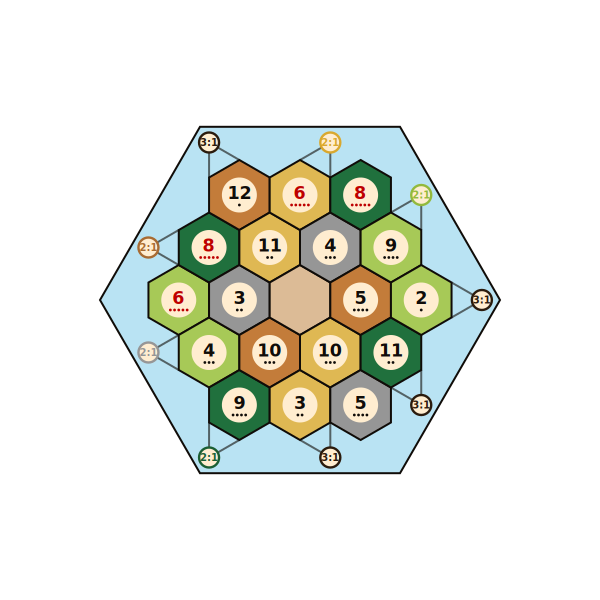

In [5]:
print(f'Minimum RS: {rs.min()}')
draw_board(layout_grid, boards[rs.argmin()], hex_grid)

The board above has the minimum possible RS score of 0, as across every axis, there's an equal number of each type of resource.

Maximum RS: 126.0


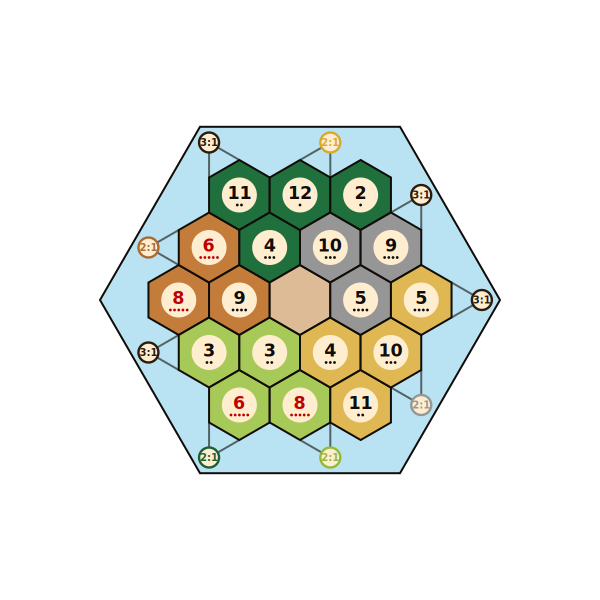

In [6]:
print(f'Maximum RS: {rs.max()}')
draw_board(layout_grid, boards[rs.argmax()], hex_grid)

Here's one of the worst boards!

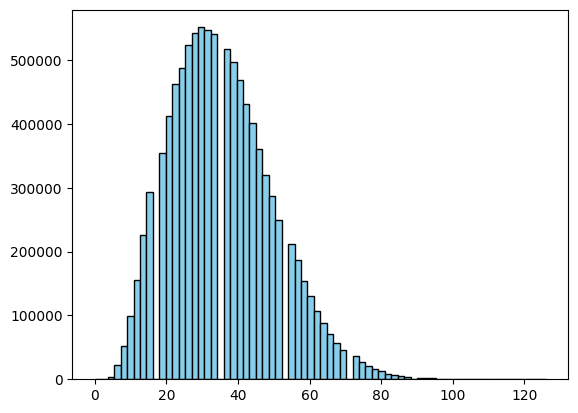

In [7]:
plt.hist(rs, bins=70, color='skyblue', edgecolor='black')
plt.show()

## 2: Resource Clustering (RC)

Generally, a board feels more balanced if you don't have hexes generating the same resource directly adjacent to one another. This measure quanitifies the amount of 'clustering' of resource types, by looking at each hex one by one, and incrementing the score by one for each neighbouring hex that produces the same resource.

In [8]:
def calc_rc(board: dict, grid: list):
    score = 0
    types = board['types']
    for h in grid:
        neighbours = hex_neighbours_map[h]
        for n in neighbours:
            if types[hex_index_map[h]] == types[hex_index_map[n]]:
                score+=1
    return score

In [9]:
rc = np.zeros(n)

for i in range(n):
    board_rc = calc_rc(boards[i], hex_grid)
    rc[i] = board_rc

Minimum RC: 0.0


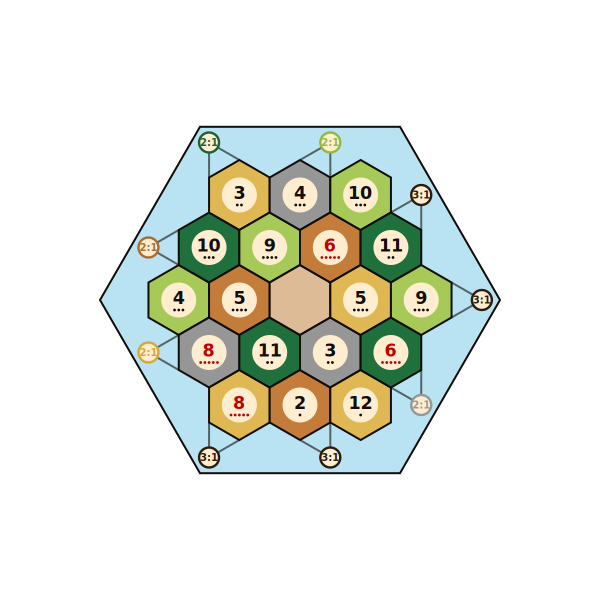

In [10]:
print(f'Minimum RC: {rc.min()}')
draw_board(layout_grid, boards[rc.argmin()], hex_grid)

This board has the lowest possible RC score, there aren't any adjacent hexes of the same type.

Maximum RC: 38.0


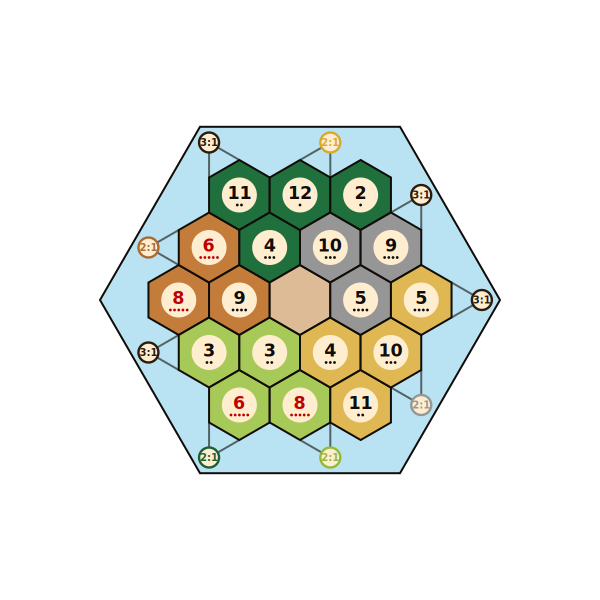

In [11]:
print(f'Maximum RC: {rc.max()}')
draw_board(layout_grid, boards[rc.argmax()], hex_grid)

On the other hand, this board has very clear clustering, reaching close to the maximum possible score.

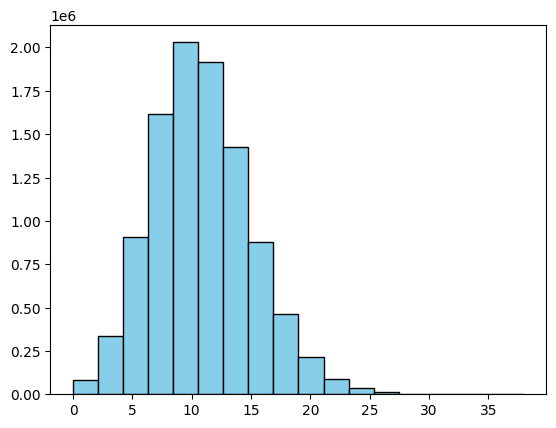

In [12]:
plt.hist(rc, bins=18, color='skyblue', edgecolor='black')
plt.show()

Intuitively, I thought that the RS and RC measures would be measuring some of the same information. You're more likely to have a less symmetrical board across all axes if you have a lot of resource clustering, and similarly, you're less likely to see clustering if the board is symmetrical along multiple axes.

Looking at the data, this seems to be the case. They're correlated with a correlation coefficient of about 0.74. That said, I think each measure captures something semantically different, and the correlation isn't strong enough for me to warrant dropping one of them at this point.

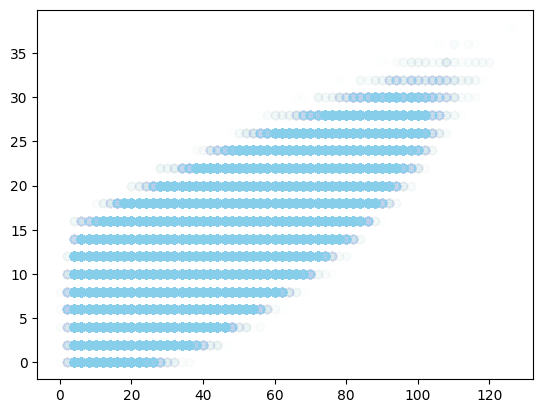

array([[1.        , 0.73396914],
       [0.73396914, 1.        ]])

In [13]:
plt.scatter(rs, rc, color='skyblue', alpha = 0.01)
plt.show()
np.corrcoef(rs, rc)

## 3. Token Symmetry (TS)

This measure applies the same idea as the RS, but measuring symmetry of tokens instead of resource types. Note that this measure actually assesses probabilities rather than the number on the tokens, 5 and 9 are different token numbers, but they have the same probability of being rolled and are so treated as the same.

In [14]:
def calc_ts(board: dict, grid: list) -> float:
    score = 0
    tokens = board['tokens']
    for axis in range(3):
        axis_score = 0
        for hex_ in grid:
            token = tokens[hex_index_map[hex_]]
            if hex_[axis] < 0:
                axis_score -= roll_freq(token)
            elif hex_[axis] > 0:
                axis_score += roll_freq(token)
        score += axis_score**2
    return score         

In [15]:
ts = np.zeros(n)

for i in range(n):
    board_ts = calc_ts(boards[i], hex_grid)
    ts[i] = board_ts

Minimum TS: 0.0


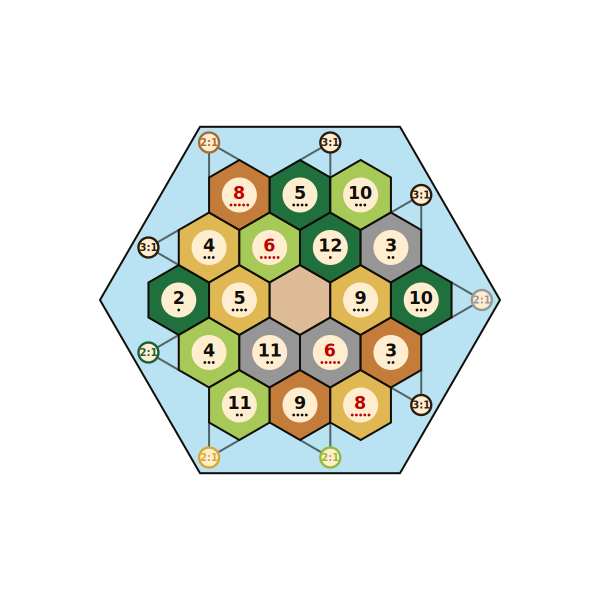

In [16]:
print(f'Minimum TS: {ts.min()}')
draw_board(layout_grid, boards[ts.argmin()], hex_grid)

On the board above, take any of the three axes, and there's an even chance of roll matching a number on either side.

Maximum TS: 565.0


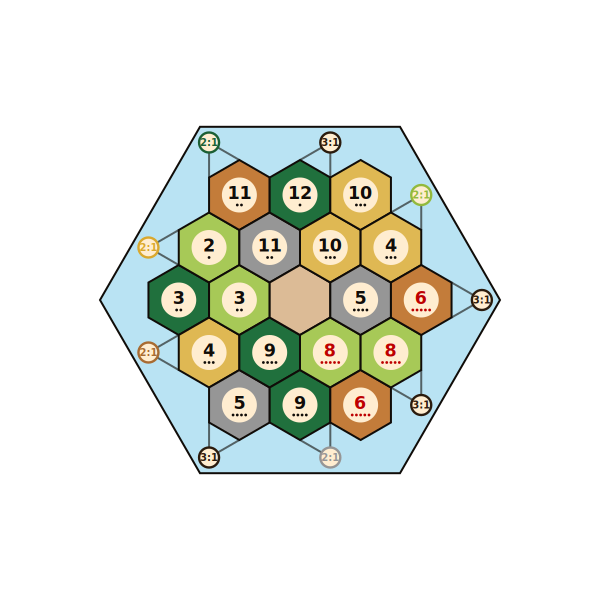

In [17]:
print(f'Maximum TS: {ts.max()}')
draw_board(layout_grid, boards[ts.argmax()], hex_grid)

This board is much less symmetrical! For example, you're much more likely to roll a number on the bottom half of the board than on the top half.

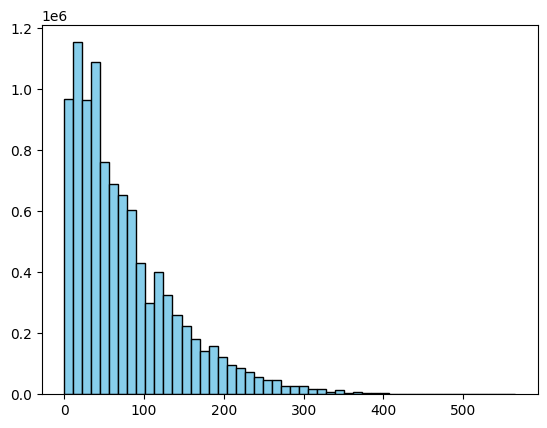

In [18]:
plt.hist(ts, bins=50, color='skyblue', edgecolor='black')
plt.show()

## 4. Token Clustering (TC)

Having hexes with adjacent token values usually makes a board less 'balanced'. The higher diversity of numbers that your settlements are placed on, the more likely you are to be able to receive resources. While being on multiple of the same token value can see a larger payout, in my opinion the increased risk doesn't feel like it's worth it.

This measure penalised boards that have hexes with the same token value adjacent. It also penalises boards that have 6 and 8 tokens adjacent, as these vertices become very high value.

In [19]:
def calc_tc(board: dict, grid: list) -> float:
    tokens = board['tokens']
    score = 0
    for hex_ in grid:
        token = tokens[hex_index_map[hex_]]
        neighbours = hex_neighbours_map[hex_]
        for n in neighbours:
            n_token = tokens[hex_index_map[n]]
            if token == n_token:
                score += 1
            if token in [6,8] and n_token in [6,8]:
                # Having the highest probability tokens adjacent is particularly imbalanced
                score += 5
    return score

In [20]:
tc = np.zeros(n)

for i in range(n):
    board_tc = calc_tc(boards[i], hex_grid)
    tc[i] = board_tc

Minimum TC: 0.0


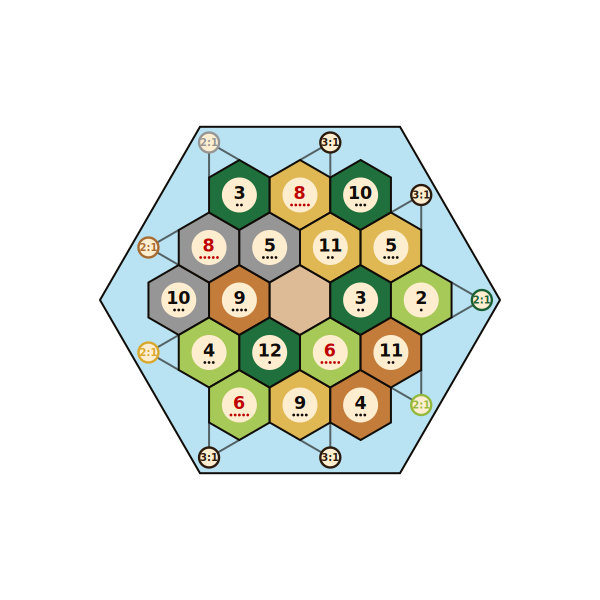

In [21]:
print(f'Minimum TC: {tc.min()}')
draw_board(layout_grid, boards[tc.argmin()], hex_grid)

The board above has no adjacent hexes with the same token value.

Maximum TC: 66.0


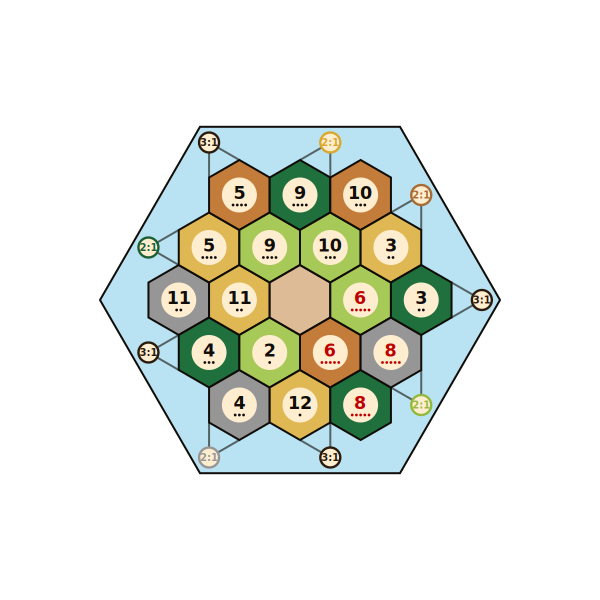

In [22]:
print(f'Maximum TC: {tc.max()}')
draw_board(layout_grid, boards[tc.argmax()], hex_grid)

This board has the highest possible TC score. Not only is every hex adjacent to a hex with the same token (except those with 2 and 12, which only appear once), but the 6 and 8 tokens are also clustered.

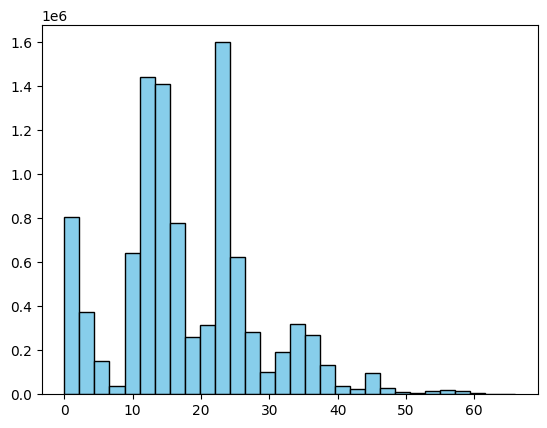

In [23]:
plt.hist(tc, bins=30, color='skyblue', edgecolor='black')
plt.show()

## 5. Tokens per Resource (TR)

This measures how likely a each resource is to produce a resource each turn. In general, I'd expect a balanced board to have a roughly equal change of generating each resource each turn (proportional to the number of hexes of that type).

In [24]:
def calc_tr(board: dict, grid: list) -> float:
    types = board['types']
    tokens = board['tokens']
    distribution = [0] * 6
    for hex_ in grid:
        type_ = types[hex_index_map[hex_]]
        token = tokens[hex_index_map[hex_]]
        if type_ != 0:
            rel_freq = 4 if type_ in [1,2,3] else 3
            distribution[type_] += roll_freq(token)/rel_freq
    return round(variance(distribution), 3)

In [25]:
tr = np.zeros(n)

for i in range(n):
    board_tr = calc_tr(boards[i], hex_grid)
    tr[i] = board_tr

Minimum TR: 1.737


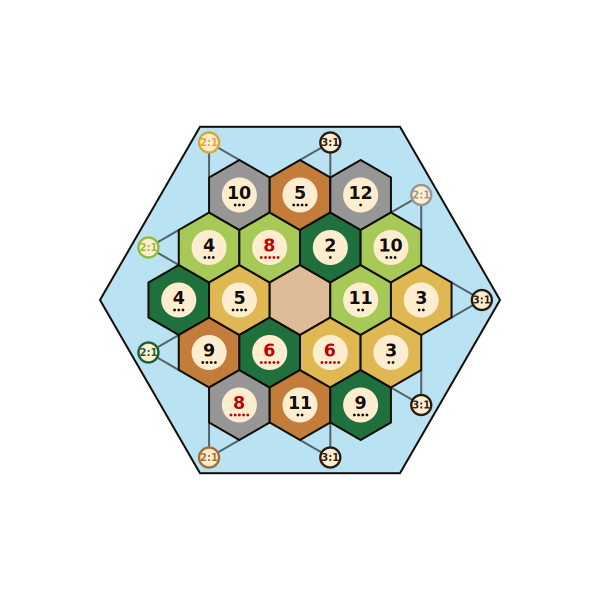

In [26]:
print(f'Minimum TR: {tr.min()}')
draw_board(layout_grid, boards[tr.argmin()], hex_grid)

In this board, note that the yellow, light-green and dark-green hexes are all about as likely to get their number rolled, and the brown and grey hexes are about the same as eachother, and proportionally lower than the others.

Maximum TR: 3.471


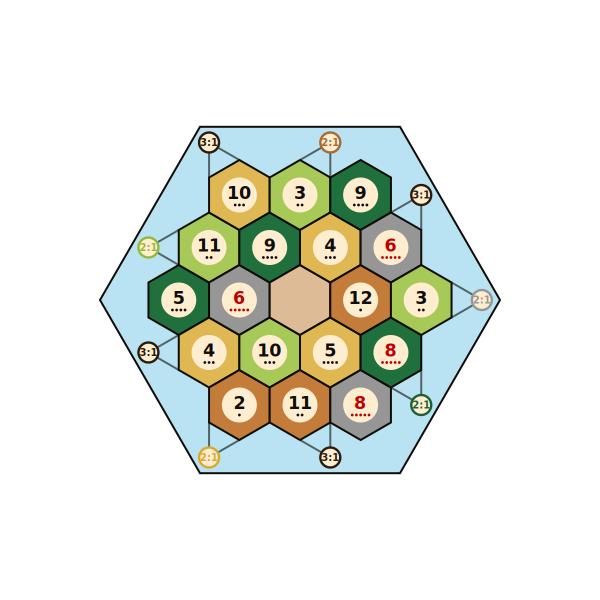

In [27]:
print(f'Maximum TR: {tr.max()}')
draw_board(layout_grid, boards[tr.argmax()], hex_grid)

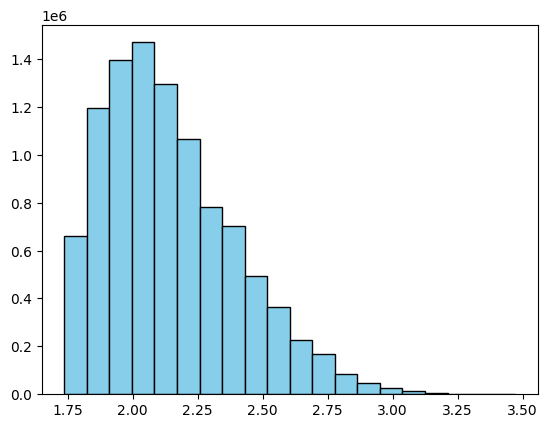

In [28]:
plt.hist(tr, bins=20, color='skyblue', edgecolor='black')
plt.show()

## 6. Harbour Value (HV)

Finally, a balanced board shouldn't have any harbours that are clearly better than all other harbours. I wasn't quite sure how to quantify this. To start, I've calculated a score for each harbour based on how valuable the hexes near the harbour are. I then take the variance of all harbour scores as the final score.

This doesn't take into account the fact that a player can collect resources from settlements further away from the port, so there's rool to improve this.

In [29]:
def calc_hv(board: dict, grid: list) -> float:
    scores = [0] * 9
    harbours = harbour_locations
    types = board['harbour_types']
    for harbour in harbours:
        harbour_i = harbour_loc_index_map[harbour]
        harbour_type = types[harbour_i]
        v0_n = vertex_to_hex_trip_map[harbour[0]]
        v1_n = vertex_to_hex_trip_map[harbour[1]]
        # Hexes that the port is directly attached to
        v_n_0 = list(set(v0_n) | set(v1_n)) 
        # Hexes that the port is distance one from
        v_n_1 = []

        for hex_ in v_n_0:
            hex_type = board['types'][hex_index_map[hex_]]
            token = board['tokens'][hex_index_map[hex_]]
            if hex_type == 0:
                score = 0 # Port has no value attached to the desert hex
            elif hex_type == harbour_type:
                score = 5/2 * roll_freq(token)
            else:
                score = roll_freq(token)

            scores[harbour_i] += score
            v_n_1 += hex_neighbours_map[hex_]

        for hex_ in v_n_1:
            hex_type = board['types'][hex_index_map[hex_]]
            token = board['tokens'][hex_index_map[hex_]]
            if hex_type == 0:
                score = 0
            elif hex_type == harbour_type:
                score = 2/3 * roll_freq(token)
            else:
                score = 1/3 * roll_freq(token)

            scores[harbour_i] += score

    return round(variance(scores), 3)

In [30]:
hv = np.zeros(n)

for i in range(n):
    board_hv = calc_hv(boards[i], hex_grid)
    hv[i] = board_hv

Minimum HV: 0.479


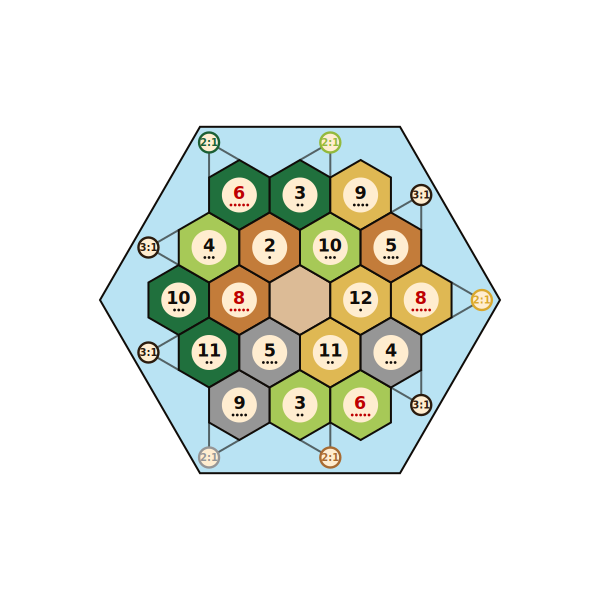

In [31]:
print(f'Minimum HV: {hv.min()}')
draw_board(layout_grid, boards[hv.argmin()], hex_grid)

Maximum HV: 183.174


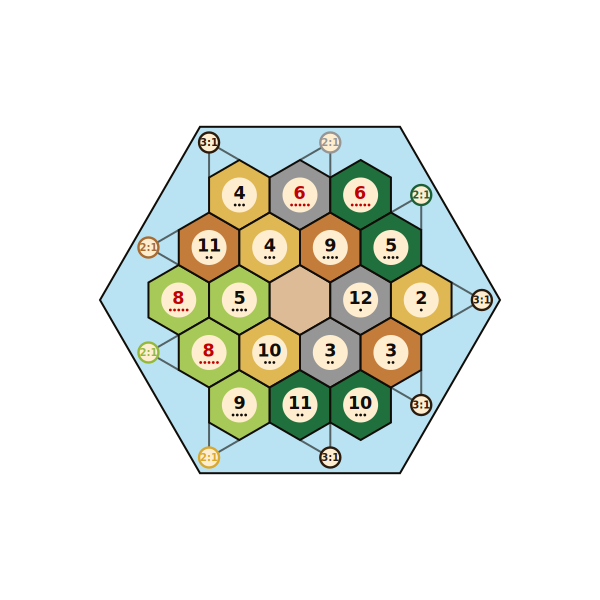

In [32]:
print(f'Maximum HV: {hv.max()}')
draw_board(layout_grid, boards[hv.argmax()], hex_grid)

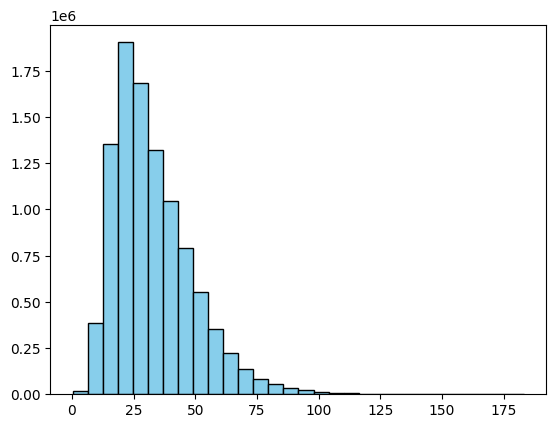

In [33]:
plt.hist(hv, bins=30, color='skyblue', edgecolor='black')
plt.show()

## Catan Board Balance Score

To get a final score, I'll take a sum of all measures after normalising. I'd like to play around with a weighted sum at some point, as intuitively some of these measures feel more important than others, but an unweighted sum seems like a fine place to start.

In [34]:
def normalise(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

In [35]:
rs_n = np.round(normalise(rs), 4)
rc_n = np.round(normalise(rc), 4)
ts_n = np.round(normalise(ts), 4)
tr_n = np.round(normalise(tr), 4)
tc_n = np.round(normalise(tc), 4)
hv_n = np.round(normalise(hv), 4)

In [36]:
cbbs = rs_n + rc_n + ts_n + tr_n + tc_n + hv_n

Minimum CBBS: 0.166
Board #: 9893874
RS: 0.0635
RC: 0.0
TS: 0.0088
TR: 0.0427
TC: 0.0
HV: 0.0507


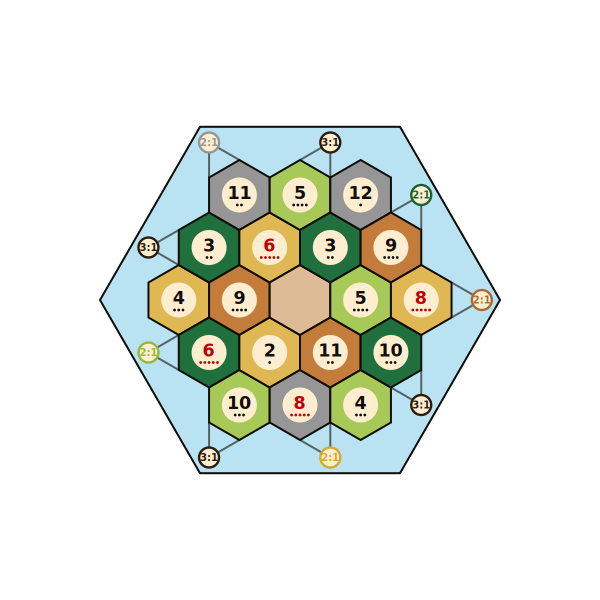

In [37]:
print(f'Minimum CBBS: {round(cbbs.min(), 3)}')
min_board_i = cbbs.argmin()
print(f'Board #: {min_board_i}')
print(f'RS: {rs_n[min_board_i]}')
print(f'RC: {rc_n[min_board_i]}')
print(f'TS: {ts_n[min_board_i]}')
print(f'TR: {tr_n[min_board_i]}')
print(f'TC: {tc_n[min_board_i]}')
print(f'HV: {hv_n[min_board_i]}')
draw_board(layout_grid, boards[cbbs.argmin()], hex_grid)

Out of ten million randomly generated boards, the CBBS determines the above board to be the most balanced. It does appear to be quite balanced by our measures, the board is relatively symmetrical, there aren't any instances of resource or token clustering, each resource appears proportionally likely to generate resources, and there aren't many harbours that stick out sa being exceptionally good or bad.

That said, note that this board doesn't do exceptionally well across all measures, it's only 6th percentile for RS and 5th for HV. If some of these mesaures had a negative correlation, indicating some tension between minimizing them both, that could explain this. However, I haven't really found much evidence for this. I think what is happening here is that ten million is only a tiny fraction of the space of total possible boards, and generating only this many leaves you unlikely to find a board that minimises all measures.

I'd like to test this at some point by changing how boards are generated. Since RS/RC and TS/TC are independent, instead of generating both resources and tokens at once, I could first generate the resources, and then measure the RS/RC score, and only admit boards that pass specified threshold scores.

Maximum CBBS: 4.1461
Board #: 5005111
RS: 0.7143
RC: 0.6316
TS: 0.8389
TR: 0.654
TC: 0.8485
HV: 0.4588


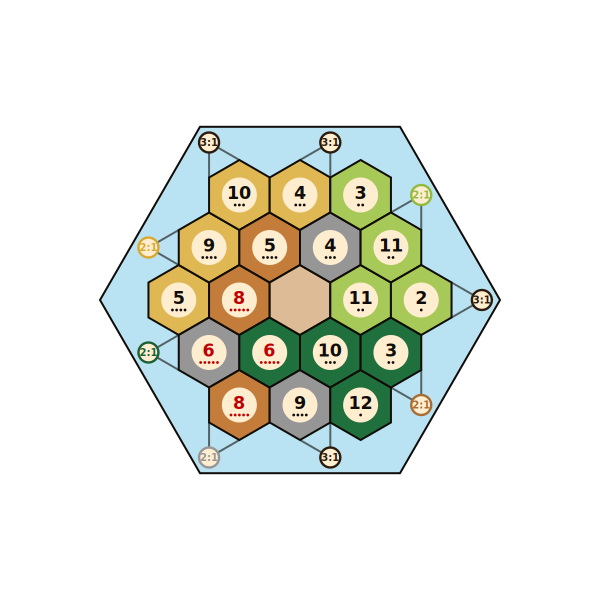

In [38]:
print(f'Maximum CBBS: {cbbs.max()}')
max_board_i = cbbs.argmax()
print(f'Board #: {max_board_i}')
print(f'RS: {rs_n[max_board_i]}')
print(f'RC: {rc_n[max_board_i]}')
print(f'TS: {ts_n[max_board_i]}')
print(f'TR: {tr_n[max_board_i]}')
print(f'TC: {tc_n[max_board_i]}')
print(f'HV: {hv_n[max_board_i]}')
draw_board(layout_grid, boards[cbbs.argmax()], hex_grid)

On the other hand, this board was found to be the worst. It's obviously not very balanced! Interestingly though, again, this board doesn't appear to be incredibly bad along every measure. In fact, it has a higher than median HV score! I don't think it'd be hard to come up with a board that has a higher score than this. (I'll give this a go when I get a chance!)

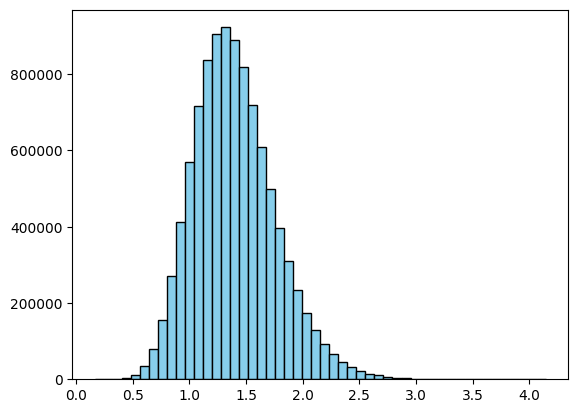

In [40]:
plt.hist(cbbs, bins=50, color='skyblue', edgecolor='black')
plt.show()

### A note

After sharing this with a friend, they pointed me to [this blog post](https://www.boardgameanalysis.com/what-is-a-balanced-catan-board/). It seems that the writer of this blog, David, beat me to the punch! I haven't yet had a close read through the whole post (I don't want to spoil my own analysis!), but we look to have ended up with a very similar set of measures, though we seem to formulate and calculate them in different ways. Their work also seems to expand much further than my scope here, so I'm looking forward to taking a closer look.